# Subway System Simulation – Analysis Notebook

This notebook analyzes the behavior of a simulated subway system using discrete event simulation. The system models 10 stations, passengers arriving over time, and trains circulating in both directions.


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV (adjust path if needed)
df = pd.read_csv('event_log.csv')
df.head()


,Time,Event,Entity,Station,Train,Direction,Destination
0,06:00,Arrives,Passenger_1,Mirasierra,NaN,NaN,Sanchinarro
1,06:00,Arrives,Passenger_2,La Moraleja,NaN,NaN,Mirasierra
2,06:00,Arrives,Passenger_3,Sanchinarro,NaN,NaN,Castellana
3,06:01,Arrives,Passenger_4,La Moraleja,NaN,NaN,Las Tablas
4,06:01,Arrives,Passenger_5,Sanchinarro,NaN,NaN,Pinar de Chamartin


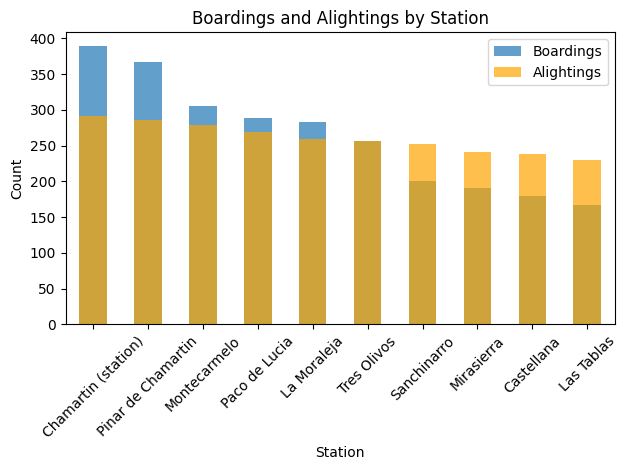

In [26]:
boardings = df[df['Event'] == 'Boards']['Station'].value_counts()
alightings = df[df['Event'] == 'Alights']['Station'].value_counts()

boardings.plot(kind='bar', alpha=0.7, label='Boardings')
alightings.plot(kind='bar', alpha=0.7, label='Alightings', color='orange')
plt.title('Boardings and Alightings by Station')
plt.xlabel('Station')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

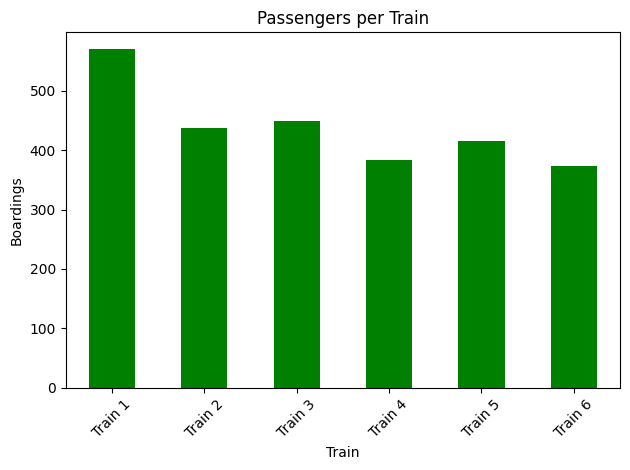

In [27]:
train_passengers = df[df['Event'] == 'Boards']['Train'].value_counts().sort_index()
train_passengers.plot(kind='bar', color='green')
plt.title('Passengers per Train')
plt.xlabel('Train')
plt.ylabel('Boardings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

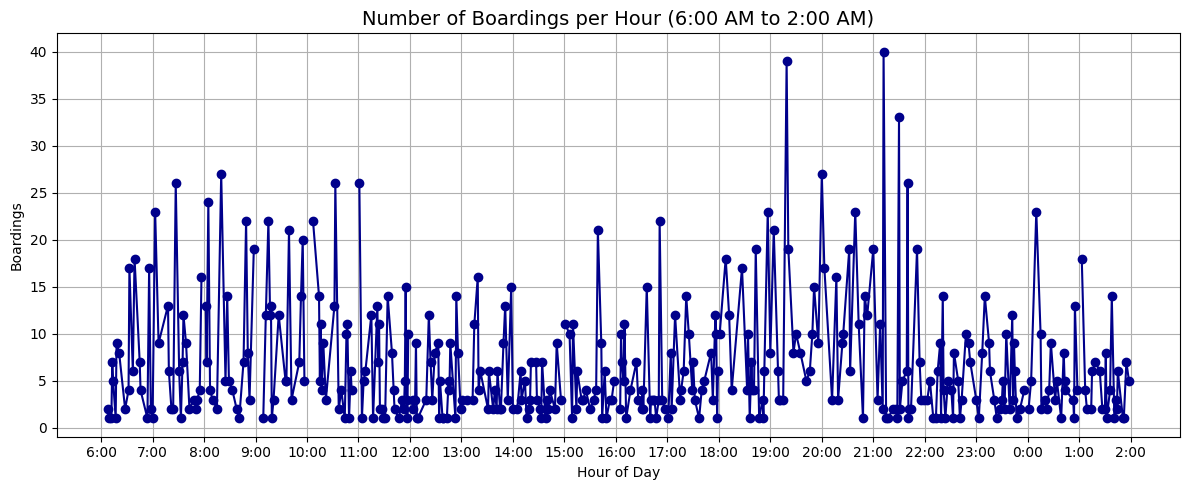

In [28]:
# We filter only boarding events
boardings = df[df['Event'] == 'Boards'].copy()

# We convert Time to datetime and we extract the hour and minutes
boardings['Time'] = pd.to_datetime(boardings['Time'], format='%H:%M')
boardings['Hour'] = boardings['Time'].dt.hour + boardings['Time'].dt.minute / 60

# We change the AM hours (0 – 2 AM) to 24 – 26
boardings['AdjustedHour'] = boardings['Hour'].apply(lambda h: h + 24 if h < 6 else h)

# We group by hour and count boardings
hourly_boardings = boardings.groupby('AdjustedHour').size()

full_range = pd.Series(index=range(6, 27), dtype='float64')
hourly_boardings = full_range.add(hourly_boardings, fill_value=0)

plt.figure(figsize=(12, 5))
plt.plot(hourly_boardings.index, hourly_boardings.values, marker='o', linestyle='-', color='darkblue')

plt.title('Number of Boardings per Hour (6:00 AM to 2:00 AM)', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Boardings')
plt.xticks(ticks=range(6, 27), labels=[f"{h%24}:00" for h in range(6, 27)])
plt.grid(True)
plt.tight_layout()
plt.show()

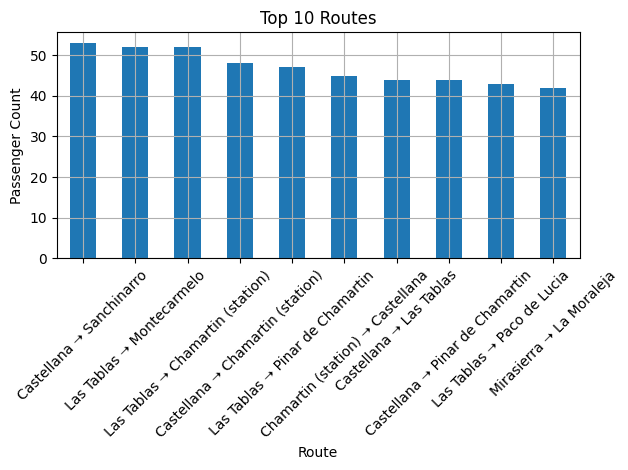

In [29]:
df_trips = df[df['Event'] == 'Boards'][['Entity', 'Station']]
destinations = df[df['Event'] == 'Alights'][['Entity', 'Station']].rename(columns={'Station': 'Destination'})
routes = pd.merge(df_trips, destinations, on='Entity')
routes['Route'] = routes['Station'] + " ➝ " + routes['Destination']

routes['Route'].value_counts().head(10).plot(kind='bar', title='Top 10 Routes')
plt.xlabel('Route')
plt.ylabel('Passenger Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

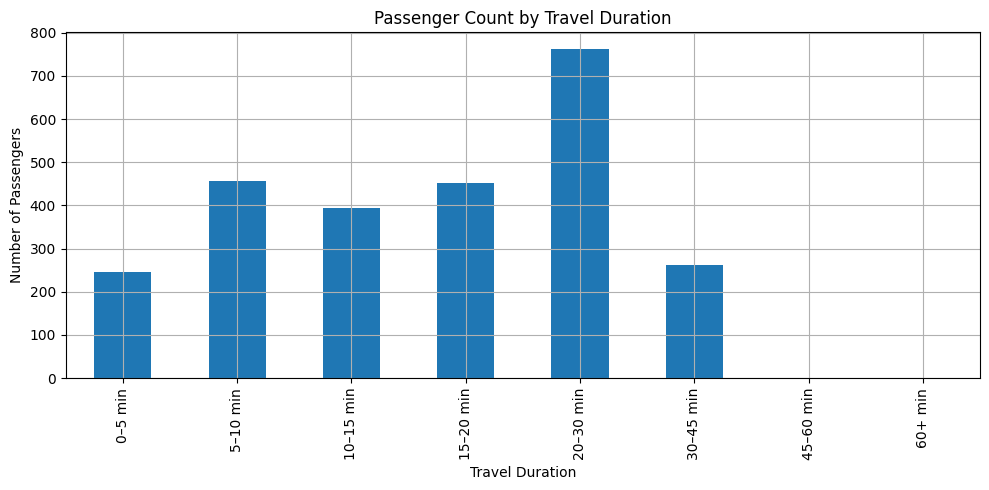

In [30]:
# We filter and merge boarding and alighting events
boards = df[df['Event'] == 'Boards'][['Entity', 'Time']].rename(columns={'Time': 'BoardingTime'})
alights = df[df['Event'] == 'Alights'][['Entity', 'Time']].rename(columns={'Time': 'AlightingTime'})
merged = pd.merge(boards, alights, on='Entity')

# Time columns to datetime objects
merged['BoardingTime'] = pd.to_datetime(merged['BoardingTime'], format='%H:%M')
merged['AlightingTime'] = pd.to_datetime(merged['AlightingTime'], format='%H:%M')

# Calculation of the travel duration
merged['TravelTime_minutes'] = (merged['AlightingTime'] - merged['BoardingTime']).dt.total_seconds() / 60

bins = [0, 5, 10, 15, 20, 30, 45, 60, float('inf')]
labels = ['0–5 min', '5–10 min', '10–15 min', '15–20 min', '20–30 min', '30–45 min', '45–60 min', '60+ min']
merged['DurationRange'] = pd.cut(merged['TravelTime_minutes'], bins=bins, labels=labels, right=False)

duration_counts = merged['DurationRange'].value_counts().sort_index()

duration_counts.plot(kind='bar', figsize=(10, 5), title='Passenger Count by Travel Duration')
plt.xlabel('Travel Duration')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.tight_layout()
plt.show()

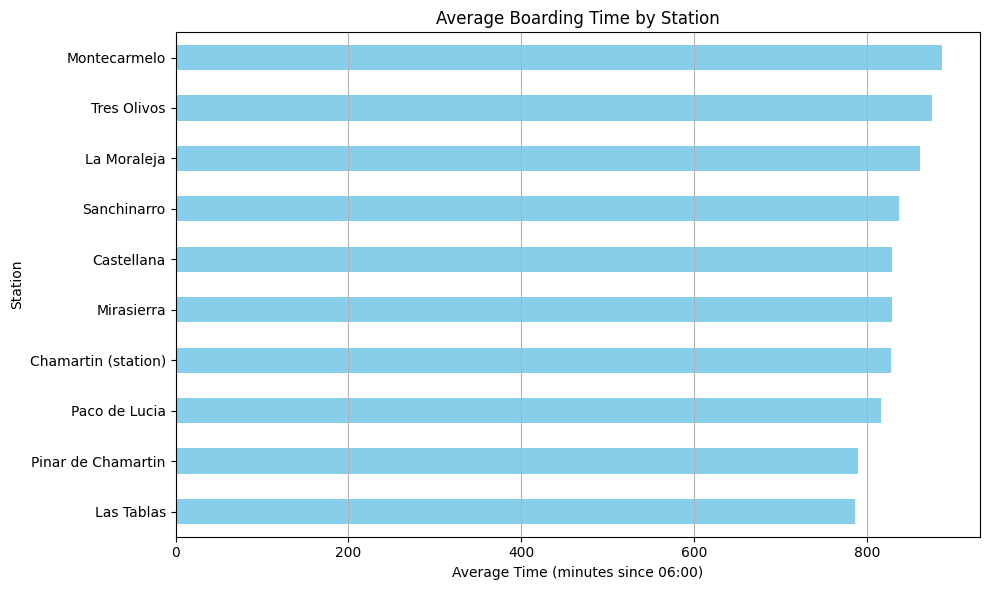

In [31]:
# We filter the boardings
df_board = df[df['Event'] == 'Boards'].copy()
df_board['Minute'] = df_board['Time'].str.split(':').apply(lambda x: int(x[0])*60 + int(x[1]))

# We calculte the the average time of boarding pero station
avg_boarding_time = df_board.groupby('Station')['Minute'].mean().sort_values()

plt.figure(figsize=(10,6))
avg_boarding_time.plot(kind='barh', color='skyblue')
plt.title('Average Boarding Time by Station')
plt.xlabel('Average Time (minutes since 06:00)')
plt.ylabel('Station')
plt.grid(axis='x')
plt.tight_layout()
plt.show()



## Conclusions

1. Some stations concentrate most of the boardings, while others receive the bulk of alightings. This reveals directional travel patterns and helps identify key origin and destination hubs within the network.

2. Passenger distribution across trains is uneven, with some units consistently more crowded. This suggests the need to optimize scheduling or capacity based on demand peaks.

3. There are clear peaks in passenger activity during morning and evening hours. These patterns reflect typical commuting behavior and should guide service frequency adjustments.

4. A few routes concentrate the majority of passenger trips, showing preferred travel corridors. These routes could benefit from targeted improvements such as higher frequency or express service options.